In [1]:
from explainn import tools
from explainn import networks
from explainn import train
from explainn import test
from explainn import interpretation

from Bio import SeqIO
import torch
import os
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import logomaker
import math
import h5py
import copy
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# for processing with peakVI check notebook - Single_cell_pancreas_PeakVI

In [3]:
df_atac_training = pd.read_csv('../peaks_by_celltype_mean_peakvi.tsv', sep="\t", index_col=0)

In [4]:
def convert_the_region(s):
    fs = s.split(":")
    chr_num = fs[0]
    start = fs[1].split("-")[0]
    end = fs[1].split("-")[1]

    mid=(int(start)+int(end))//2
    new_start = mid-101
    new_end = mid+100

    output = 'chr'+str(chr_num)+":"+str(new_start)+"-"+str(new_end)+"()"
    return output

new_ind = [convert_the_region(i) for i in df_atac_training.index]
new_ind = np.array(new_ind)
df_atac_training.index = new_ind

#drop Y chromosomes
chrYs = []
for i in range(len(df_atac_training.index)):
    if df_atac_training.index[i].startswith("chrY"):
        chrYs.append(i)
        
df_atac_training = df_atac_training.drop(df_atac_training.index[chrYs])

In [5]:
df_atac_training.head()

,alpha_2,beta_2,immune,alpha_1,beta_1,delta_2,delta_1,acinar,ductal,gamma,endothelial,stellate
chr1:100009943-100010144(),0.025972,0.140406,0.094703,0.020963,0.126555,0.072435,0.037665,0.089063,0.110462,0.034918,0.084784,0.186589
chr1:100014788-100014989(),0.018623,0.071533,0.028600,0.026508,0.104760,0.019076,0.017249,0.013615,0.014350,0.020607,0.012025,0.012036
chr1:100017761-100017962(),0.031992,0.032712,0.007027,0.004293,0.003657,0.036808,0.004231,0.007534,0.008008,0.003811,0.004625,0.011335
chr1:100023515-100023716(),0.035797,0.027060,0.038204,0.005420,0.007367,0.061814,0.008533,0.048994,0.063749,0.005873,0.054482,0.151951
chr1:10003192-10003393(),0.272739,0.212730,0.261435,0.225892,0.202386,0.220377,0.197521,0.286331,0.269792,0.217983,0.369146,0.329510


In [ ]:
with open("../islet_sites_201.bed","w") as f:
    for ind in df_atac_training.index:
        f.write(ind.split(":")[0]+'\t')
        f.write(ind.split(":")[-1].split("-")[0]+'\t')
        f.write(ind.split(":")[-1].split("-")[-1]+'\n')

In [ ]:
%%bash
. ~/.bashrc
bedtools getfasta -fi ../hg19/hg19.fa -bed ../islet_sites_201.bed -s -fo ../islet_sites_201.fa

# Split the data

In [ ]:
import numpy as np
import pandas as pd
from Bio import SeqIO
import pickle
import sys
import h5py
import tqdm
import numpy.random as npr
from Bio import Seq
from tools import *

In [ ]:
Seed = 1
test_pct = 0.1
valid_pct = 0.1

tf_peaks = pd.read_csv("../islet_sites_201_act_quantilelognorm.txt", index_col=0, sep="\t")

fasta_seq = SeqIO.parse(open("../islet_sites_201.fa"),'fasta')

fasta_sequences = {}
for fasta in fasta_seq:
    name, sequence = fasta.id, str(fasta.seq)
    
    if "N" in sequence.upper():
        continue

    fasta_sequences[name] = sequence.upper()

fasta_sequences = pd.Series(fasta_sequences)

tf_peaks = tf_peaks.loc[fasta_sequences.index, :]

####################################
#shuffle the sequence
####################################
npr.seed(int(Seed)) #setting a seed

order = npr.permutation(tf_peaks.index)
tf_peaks = tf_peaks.reindex(order) #labels
fasta_sequences = fasta_sequences.reindex(order) #sequences
print("Done shuffling")
####################################

test_count = int(0.5 + float(test_pct) * tf_peaks.shape[0])
valid_count = int(0.5 + float(valid_pct) * tf_peaks.shape[0])
train_count = tf_peaks.shape[0] - test_count - valid_count

print('%d training sequences ' % train_count)
print('%d test sequences ' % test_count)
print('%d validation sequences ' % valid_count)

####################################
#shuffle the sequence
####################################
i = 0
train_peaks, train_sequences = tf_peaks.iloc[i:i+train_count,:], fasta_sequences[i:i+train_count]
i += train_count
valid_peaks, valid_sequences = tf_peaks.iloc[i:i+valid_count,:], fasta_sequences[i:i+valid_count]
i += valid_count
test_peaks, test_sequences = tf_peaks.iloc[i:i+test_count,:], fasta_sequences[i:i+test_count]
####################################

####################################
#saving TF labels and sequences ids
#which we used for training/validation
####################################
target_labels = list(tf_peaks)
train_peaks.index = train_peaks.index.map(str)
valid_peaks.index = valid_peaks.index.map(str)
test_peaks.index = test_peaks.index.map(str)

train_headers = train_peaks.index
valid_headers = valid_peaks.index

target_labels = [a.encode('utf8') for a in target_labels]
train_headers = [a.encode('utf8') for a in train_headers]
valid_headers = [a.encode('utf8') for a in valid_headers]
####################################

####################################
#one hot encoding
####################################
train_sequences = train_sequences.map(lambda x: tools.dna_one_hot(x, flatten=False))
train_sequences = np.stack(train_sequences, axis=0)

valid_sequences = valid_sequences.map(lambda x: tools.dna_one_hot(x, flatten=False))
valid_sequences = np.stack(valid_sequences, axis=0)

test_sequences = test_sequences.map(lambda x: tools.dna_one_hot(x, flatten=False))
test_sequences = np.stack(test_sequences, axis=0)
print("Done encoding the data")
####################################

In [ ]:
####################################
#saving the data
####################################
train_peaks = train_peaks.values
valid_peaks = valid_peaks.values
test_peaks = test_peaks.values

h5f = h5py.File("../islet_data_scvi_201.h5", 'w')

h5f.create_dataset('target_labels', data=target_labels)

h5f.create_dataset('train_in', data=train_sequences)
h5f.create_dataset('train_out', data=train_peaks)
h5f.create_dataset('train_headers', data=train_headers)

h5f.create_dataset('valid_in', data=valid_sequences)
h5f.create_dataset('valid_out', data=valid_peaks)
h5f.create_dataset('valid_headers', data=valid_headers)

h5f.create_dataset('test_in', data=test_sequences)
h5f.create_dataset('test_out', data=test_peaks)

h5f.close()
print("Data saved, you are good to go")

# Training

In [6]:
num_epochs = 10
batch_size = 100 
learning_rate = 0.001 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

dataloaders, target_labels, train_out = tools.load_datas("../islet_data_scvi_201.h5", 
                                                         batch_size, 4, True)

target_labels = [i.decode("utf-8") for i in target_labels]
    
target_labels

Dataset Loaded


['alpha_2',
 'beta_2',
 'immune',
 'alpha_1',
 'beta_1',
 'delta_2',
 'delta_1',
 'acinar',
 'ductal',
 'gamma',
 'endothelial',
 'stellate']

In [8]:
learning_rate = 0.001
num_classes = 12

input_length = 201
num_cnns = 400

explainn = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size=19).to(device)

criterion = tools.pearson_loss
optimizer = torch.optim.Adam(explainn.parameters(), lr=learning_rate)

In [ ]:
os.makedirs("../CAM_Pancreas_400_long")
num_epochs = 50

model, train_error, test_error = train.train_explainn(dataloaders["train"], dataloaders['valid'], 
                                                      explainn, device, criterion, 
                                                      optimizer, num_epochs,
                                                      "../CAM_Pancreas_400_long", "", 
                                                      verbose=True, trim_weights=False)

print("Min test error:")
print(min(test_error))

In [9]:
explainn.load_state_dict(torch.load("../CAM_Pancreas_400_long/model_epoch_26_.pth")) #No TL
explainn.eval();

In [10]:
predictions, labels_true = interpretation.get_explainn_predictions(dataloaders["test"], explainn, device) 

correlations = []

for i in range(len(predictions)):
    x = np.corrcoef(predictions[i, :], labels_true[i, :])[0, 1]
    correlations.append(x)

#weighted_cor = np.dot(correlations, vars) / np.sum(vars)

nan_cors = [value for value in correlations if math.isnan(value)]
correlations = [value for value in correlations if not math.isnan(value)]

print(np.mean(correlations))
print(np.where(np.array(correlations) >= 0.75)[0].shape)

0.33578029275688526
(5634,)


# Interpretation 

In [11]:
num_classes = 12
num_cnns = 400


batch_size = 100
data = h5py.File("../islet_data_scvi_201.h5", 'r')

x = torch.Tensor(np.array(data['train_in']))
y = torch.Tensor(np.array(data['valid_in']))
z = torch.Tensor(np.array(data['test_in']))

x_lab = torch.Tensor(np.array(data['train_out']))
y_lab = torch.Tensor(np.array(data['valid_out']))
z_lab = torch.Tensor(np.array(data['test_out']))

res = torch.cat((x,y,z), dim=0)
res_lab = torch.cat((x_lab,y_lab,z_lab), dim=0)

all_dataset = torch.utils.data.TensorDataset(res, res_lab)
data_loader = torch.utils.data.DataLoader(all_dataset, 
                                                  batch_size=128, shuffle=False,
                                                  num_workers=0)

In [12]:
predictions, labels_true = interpretation.get_explainn_predictions(data_loader, explainn, device) 

#well-predicted only
correlations = []
vars = []
for i in range(len(predictions)):
    var = np.var(labels_true[i, :])
    vars.append(var)
    x_ = np.corrcoef(predictions[i, :], labels_true[i, :])[0, 1]
    correlations.append(x_)

correlations = [value for value in correlations if not math.isnan(value)]

idx = np.argwhere(np.asarray(correlations) > 0.85).squeeze()
idx.shape

(59803,)

In [13]:
x2 = res[idx, :, :]
y2 = res_lab[idx, :]

dataset = torch.utils.data.TensorDataset(x2, y2)
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

In [ ]:
activations = interpretation.get_explainn_unit_activations(data_loader, explainn, device)
pwms = interpretation.get_pwms_explainn(activations, x2, y2, filter_size)

interpretation.pwm_to_meme("../CAM_Pancreas_400_long_26.meme")

100%|██████████| 599/599 [00:14<00:00, 41.32it/s]


In [ ]:
%%bash
. ~/.bashrc
./../../../meme-5.3.3/src/tomtom -oc ../../../tomtom_results/tomtom_CAM_Pancreas_400_long_26 ../CAM_Pancreas_400_long_26.meme ../../../tomtom_results/JASPAR2020_CORE_vertebrates_non-redundant_pfms_meme.txt > /dev/null 2>&1

In [25]:
tomtom_results = pd.read_csv("../../../tomtom_results/tomtom_CAM_Pancreas_400_long_26/tomtom.tsv",
                                    sep="\t",comment="#")

filters_with_min_q = tomtom_results.groupby('Query_ID').min()["q-value"]

tomtom_results = tomtom_results[["Target_ID", "Query_ID", "q-value"]]
tomtom_results = tomtom_results[tomtom_results["q-value"]<0.05]

cisbp_motifs = {}
with open("../../../tomtom_results/JASPAR2020_CORE_vertebrates_non-redundant_pfms_meme.txt") as f:
    for line in f:
        if "MOTIF" in line:
            motif = line.strip().split()[-1]
            name_m = line.strip().split()[-2]
            cisbp_motifs[name_m] = motif
            
filters = tomtom_results["Query_ID"].unique()
annotation = {}
for f in filters:
    t = tomtom_results[tomtom_results["Query_ID"] == f]
    target_id = t["Target_ID"]
    if len(target_id) > 5:
        target_id = target_id[:5]
    ann = "/".join([cisbp_motifs[i] for i in target_id.values])
    annotation[f] = ann
    
filters_ind = np.array([int(i.split("filter")[-1]) for i in annotation.keys()])

annotation = pd.Series(annotation)

In [15]:
annotation.values

array(['CTCF', 'Zic2/Zic1::Zic2', 'Mafb/MAFG/NRL/MAFF/MAF', 'Foxl2',
       'GATA1::TAL1/GATA5/GATA2/GATA6/GATA3',
       'SNAI1/ASCL1(var.2)/SNAI3/SNAI2/TCF4', 'EHF/IKZF1/ELF5/ELF1/ETV4',
       'EHF/ELF3/SPI1/SPIB/ELF1', 'Foxj3', 'TEAD1/TEAD4/TEAD2',
       'NRL/MAFF/MAFG/Mafb/MAF::NFE2', 'NKX2-5/NKX2-8/NKX2-3',
       'POU6F1(var.2)/POU6F2/HOXB4/HOXC4/EVX2', 'TEAD2/TEAD4/TEAD3/TEAD1',
       'Pparg::Rxra', 'RFX1/RFX3/RFX7', 'ZFP42',
       'IKZF1/GABPA/ETV4/EHF/ETV1', 'RFX1/RFX3', 'EBF1/EBF3/Ebf2',
       'Smad2::Smad3/FOSL1::JUN/FOSL1/BATF::JUN/BATF',
       'Ptf1a(var.2)/MYF5/Zic2/Rbpjl/BHLHA15(var.2)',
       'HEY2/HES2/BHLHE40/PBX3/TFEB', 'NFIX',
       'JUND(var.2)/ATF2/JUNB(var.2)/ATF3/FOS::JUN(var.2)',
       'ELF1/ETV1/EHF/ELF3/GABPA', 'GABPA/EHF/ELF1/ETV1/ELF3',
       'IKZF1/GABPA/ETV1/EHF/ELF3', 'Isl1/NEUROG2(var.2)/NEUROD1',
       'FOSL1::JUN/FOS::JUND/Smad2::Smad3/FOSL1::JUNB/FOSL2::JUN',
       'ZEB1/Rbpjl/TCF4/SNAI2/ASCL1(var.2)',
       'JUNB/FOSL1/JUND/FOSL2::JUN/F

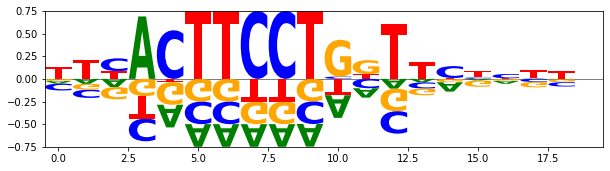

In [19]:
filterid=331

motifs, motif_names = tools.read_meme('../CAM_Pancreas_400_long_26.meme')

x = [list(i) for i in motifs[filterid]]
pwm = tools._PWM_to_filter_weights(x, 20)
nn_logo = logomaker.Logo(pd.DataFrame(data=pwm,columns = ["A","C", "G","T"]))

# Weights

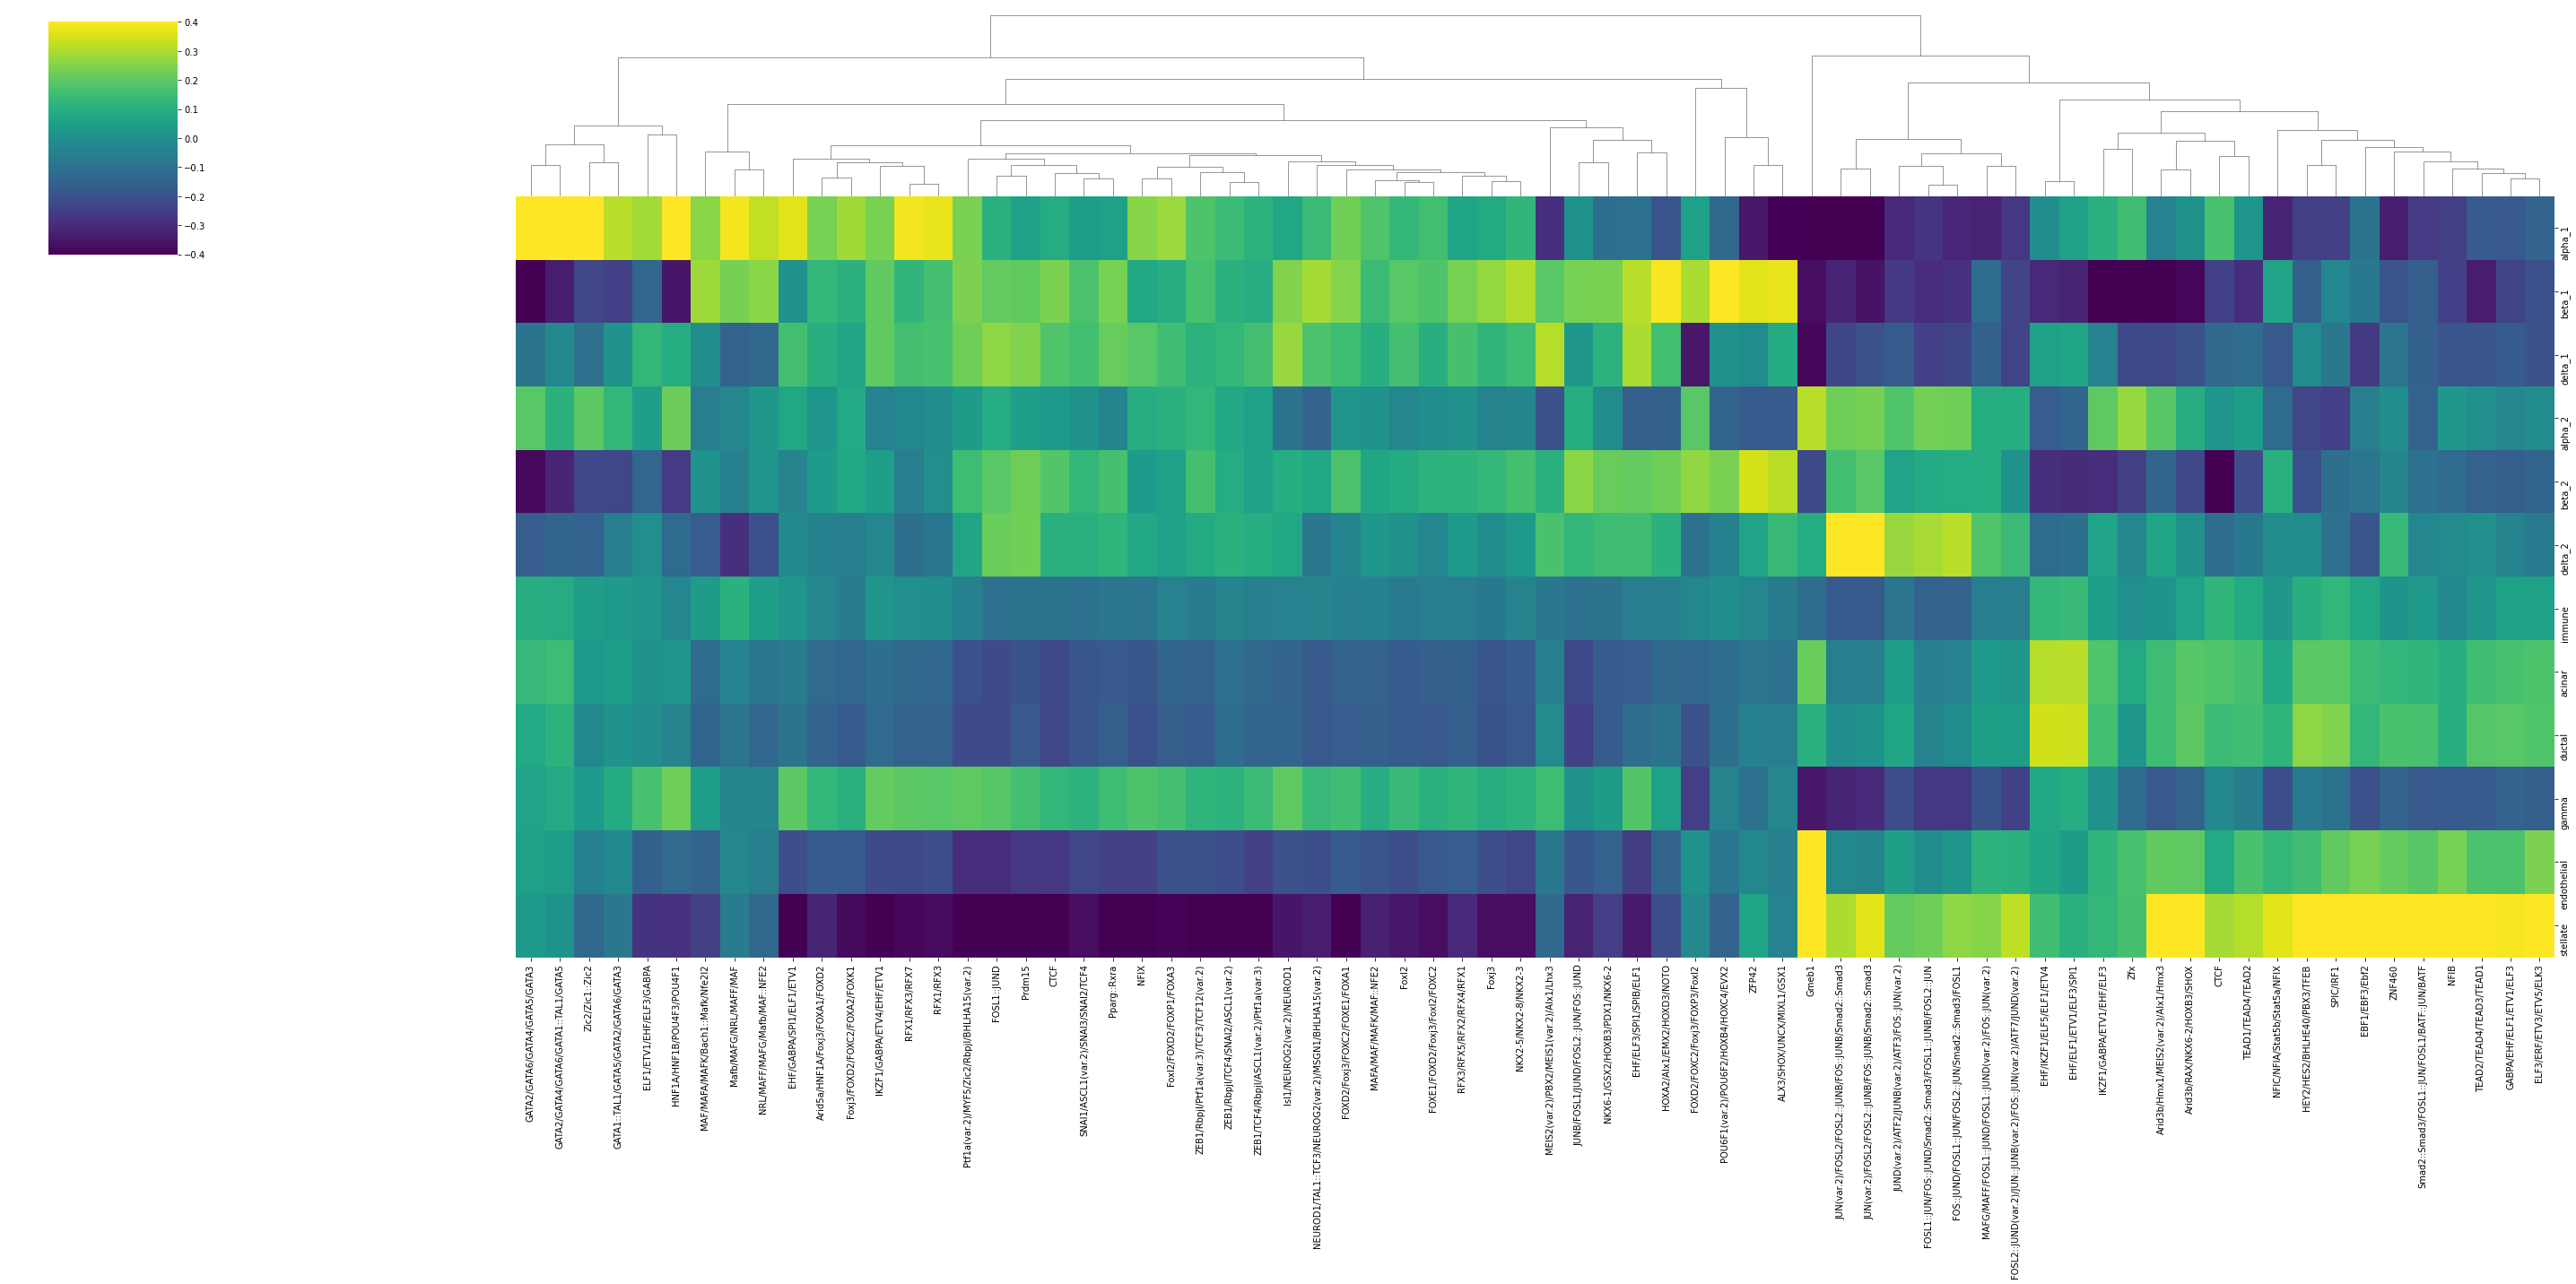

In [26]:
target_labels = ['alpha_2','beta_2','immune','alpha_1','beta_1','delta_2','delta_1',
                 'acinar','ductal','gamma','endothelial','stellate']

annotation_new_ind = [int(i.split("filter")[-1]) for i in annotation.index]
filter_dict_400 = annotation
filter_dict_400.index = annotation_new_ind

weights = explainn.final.weight.detach().cpu().numpy()

filters = [str(i) for i in range(400)]
for i in filter_dict_400.keys():
    filters[i] = filter_dict_400[i]
    
weight_df = pd.DataFrame(weights,index=target_labels,columns=filters)

weight_df = weight_df.reindex(['alpha_1','beta_1','delta_1','alpha_2','beta_2','delta_2','immune',
                 'acinar','ductal','gamma','endothelial','stellate'])


weight_annotated_cols = np.where([not i.isnumeric() for i in weight_df.columns])[0]
weight_df_annotated = weight_df.iloc[:, weight_annotated_cols]

sns.clustermap(weight_df_annotated,cmap="viridis", col_cluster=True,
               row_cluster=False,figsize=(40,20), vmax=0.4, vmin=-0.4)

# Importance

In [ ]:
unit_outputs = interpretation.get_explainn_unit_outputs(data_loader, explainn, device)

for filt in tqdm(range(400)):
    res_distr = interpretation.get_specific_unit_importance(activations, model, unit_outputs, filt, columns)

    filter_key = "filter"+str(filt)
    title = annotation[filter_key] if filter_key in annotation.index else filter_key
    fig, ax = plt.subplots()
    datas = [filt_dat for filt_dat in res_distr]
    ax.boxplot(datas, notch=True, patch_artist=True)
    fig.set_size_inches(18.5, 10.5)
    plt.title(title)
    plt.ylabel("Filter importance")
    plt.xticks(range(1, 13), target_labels)
    plt.xticks(rotation=90)
    fig.savefig('../CAM_FIGURE_5_BOXPLOTS/'+filter_key+'.png')
    plt.close()